### Loading a pretrained LLM

We must load a pretrained GPT model that we want to fine-tune. This time, we will load the medium-sized model with 355 million parameters. The smaller model would be too limited in capacity to achieve satisfactory results via instruction fine-tuning. Smaller models lack the capacity to learn and retain the intricate patterns and nuanced behaviours for instruction-following tasks. 

In [1]:
from gpt_download import download_and_load_gpt2
from Chapter04 import GPTModel
from Chapter05 import load_weights_into_gpt

BASE_CONFIG = {
    "vocab_size": 50_257,
    "context_length": 1024,
    "drop_rate": 0.0,
    "qkv_bias": True
}

model_configs = {
    "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
    "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
    "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
    "gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
}

CHOOSE_MODEL = "gpt2-medium (355M)"
BASE_CONFIG.update(model_configs[CHOOSE_MODEL])

model_size = CHOOSE_MODEL.split(" ")[-1].lstrip("(").rstrip(")")

settings, params = download_and_load_gpt2(
    model_size=model_size,
    models_dir="gpt2"
)

model = GPTModel(BASE_CONFIG)
load_weights_into_gpt(model, params)
model.eval();

File already exists and is up-to-date: gpt2\355M\checkpoint
File already exists and is up-to-date: gpt2\355M\encoder.json
File already exists and is up-to-date: gpt2\355M\hparams.json
File already exists and is up-to-date: gpt2\355M\model.ckpt.data-00000-of-00001
File already exists and is up-to-date: gpt2\355M\model.ckpt.index
File already exists and is up-to-date: gpt2\355M\model.ckpt.meta
File already exists and is up-to-date: gpt2\355M\vocab.bpe


Let's quickly assess this model's performance on one of the validation tasks by comparing it's output to the expected response. This will give us an idea of the model's performance before fine-tuning, and help us appreciate the effect of fine-tuning later on.

In [2]:
from Chapter07 import (
    format_input, train_data, val_data, test_data
)

print("Training set length:", len(train_data))
print("Validation set length:", len(val_data))
print("Test set length:", len(test_data))

Training set length: 935
Validation set length: 55
Test set length: 110


In [3]:
import torch

torch.manual_seed(123)
input_text = format_input(val_data[0])
print(input_text)

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Convert the active sentence to passive: 'The chef cooks the meal every day.'


In [4]:
from Chapter05 import generate, text_to_token_ids, token_ids_to_text, tokeniser

token_ids = generate(
    model=model,
    idx=text_to_token_ids(input_text, tokeniser),
    max_new_tokens=35,
    context_size=BASE_CONFIG["context_length"],
    eos_id=50_256
)
generated_text = token_ids_to_text(token_ids, tokeniser)

The generate function returns the combined input and output text, which was convenient for text-completion. However, when evaluating a model's performance on a specific task, we want to focus solely on the model's generated response. To isolate this, we need to subtract the length of the input instruction from the start of the generated text.

In [5]:
# Without stripping
print(generated_text)

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Convert the active sentence to passive: 'The chef cooks the meal every day.'

"I'm not a fan of the American people's love of the United States of America, but I'm not a fan of the United States of America.



In [6]:
# With stripping text
response_text = generated_text[len(input_text):].strip()
print(response_text)

"I'm not a fan of the American people's love of the United States of America, but I'm not a fan of the United States of America.


### Fine-tuning the LLM on instruction data

In [7]:
from Chapter05 import (
    calc_loss_loader,
    train_model_simple
)
from Chapter07 import (
    device, train_loader, val_loader, test_loader
)

model.to(device)
torch.manual_seed(123)

# Initial loss before training
with torch.no_grad():
    train_loss = calc_loss_loader(
        train_loader, model, device, num_batches=5
    )
    val_loss = calc_loss_loader(
        val_loader, model, device, num_batches=5
)

print("Training loss:", train_loss)
print("Validation loss:", val_loss)

Training loss: 5.437087345123291
Validation loss: 5.363913440704346


In [8]:
# Train the model
import time

start_time = time.time()
torch.manual_seed(123)
optimiser = torch.optim.AdamW(
    model.parameters(), lr=0.00005, weight_decay=0.1
)
num_epochs = 2

train_losses, val_losses, tokens_seen = train_model_simple(
    model, train_loader, val_loader, optimiser, device,
    num_epochs=num_epochs, eval_freq=5, eval_iter=5,
    start_context=format_input(val_data[0]), tokeniser=tokeniser
)

end_time = time.time()
execution_time_mins = (end_time - start_time) / 60
print(f"Training completed in {execution_time_mins:.2f} minutes.")

Epoch 1 (Step 000000): Train loss 4.451, Val loss 4.433
Epoch 1 (Step 000005): Train loss 1.601, Val loss 1.489
Epoch 1 (Step 000010): Train loss 1.051, Val loss 1.138
Epoch 1 (Step 000015): Train loss 0.982, Val loss 1.026
Epoch 1 (Step 000020): Train loss 0.860, Val loss 0.970
Epoch 1 (Step 000025): Train loss 0.828, Val loss 0.926
Epoch 1 (Step 000030): Train loss 0.854, Val loss 0.900
Epoch 1 (Step 000035): Train loss 0.773, Val loss 0.869
Epoch 1 (Step 000040): Train loss 0.720, Val loss 0.850
Epoch 1 (Step 000045): Train loss 0.670, Val loss 0.837
Epoch 1 (Step 000050): Train loss 0.719, Val loss 0.827
Epoch 1 (Step 000055): Train loss 0.792, Val loss 0.812
Epoch 1 (Step 000060): Train loss 0.750, Val loss 0.788
Epoch 1 (Step 000065): Train loss 0.672, Val loss 0.769
Epoch 1 (Step 000070): Train loss 0.579, Val loss 0.761
Epoch 1 (Step 000075): Train loss 0.592, Val loss 0.758
Epoch 1 (Step 000080): Train loss 0.642, Val loss 0.752
Epoch 1 (Step 000085): Train loss 0.541, Val los

Without a GPU, this takes 42 minutes. With a GPU, it took Raschka's model less than a minute to train. 

According to the output, the model is learning effectively - the training and validation loss values decrease over time, which suggests that the model is gradually improving its ability to understand and follow the provided instructions. Perhaps even one epoch would have been enough as the validation loss plateaued after the first epoch. 

After the first epoch, it would appear that the model isn't learning but after the second epoch it correctly converts the active sentence to the passive voice. The plot below shows that the model is training effectively. 

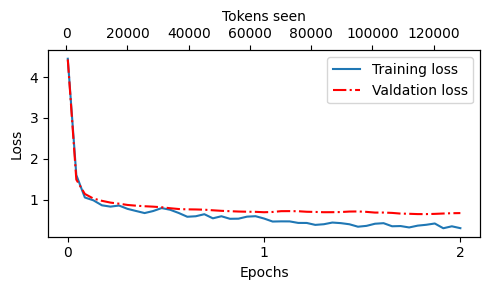

In [ ]:
from Chapter05 import plot_losses
epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)

#### Extracting and saving responses

The most crucial aspect is the model's performance in terms of response quality and correctness. Let's extract the responses and store them in a format that allows us to evaluate and quantify the response quality.

In [16]:
torch.manual_seed(123)

# First 3 entries
for entry in test_data[:3]:
    input_text = format_input(entry)
    token_ids = generate(
        model=model,
        idx=text_to_token_ids(input_text, tokeniser).to(device),
        max_new_tokens=256,
        context_size=BASE_CONFIG["context_length"],
        eos_id=50_256
    )
generated_text = token_ids_to_text(token_ids, tokeniser)#

response_text = (
    generated_text[len(input_text):]
    .replace("### Response:", "")
    .strip()
)
print(input_text)
print(f"\nCorrect response:\n>> {entry['output']}")
print(f"\nModel response:\n>> {response_text.strip()}")
print("--------------------------------------")

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Name the author of 'Pride and Prejudice'.

Correct response:
>> Jane Austen.

Model response:
>> The author of 'Pride and Prejudice' is Jane Austen.
--------------------------------------


#### Save the model

In [17]:
import re

file_name = f"{re.sub(f'[ ()]', '', CHOOSE_MODEL) }-sft.pth"
torch.save(model.state_dict(), file_name)
print(f"Model saved as {file_name}")

Model saved as gpt2-medium355M-sft.pth
